<a href="https://colab.research.google.com/github/ramapu12/trabajoFinal/blob/main/trabajoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores par√°metros encontrados: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 1.55
RMSE: 2.28
R¬≤: 0.94
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c6f8d0dbc863cc0bb2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


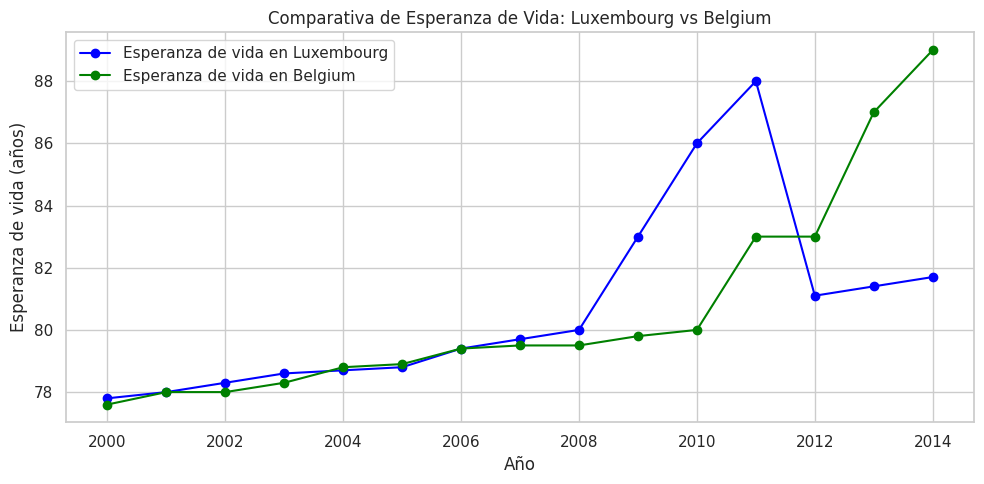

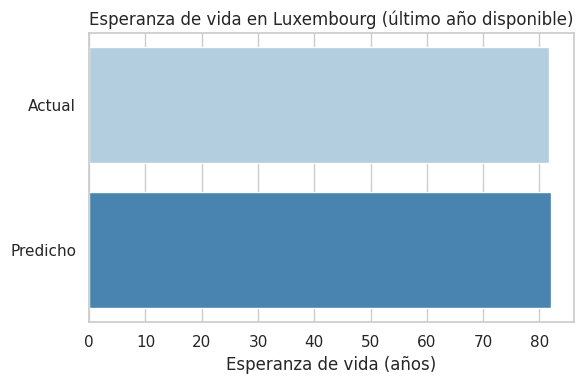

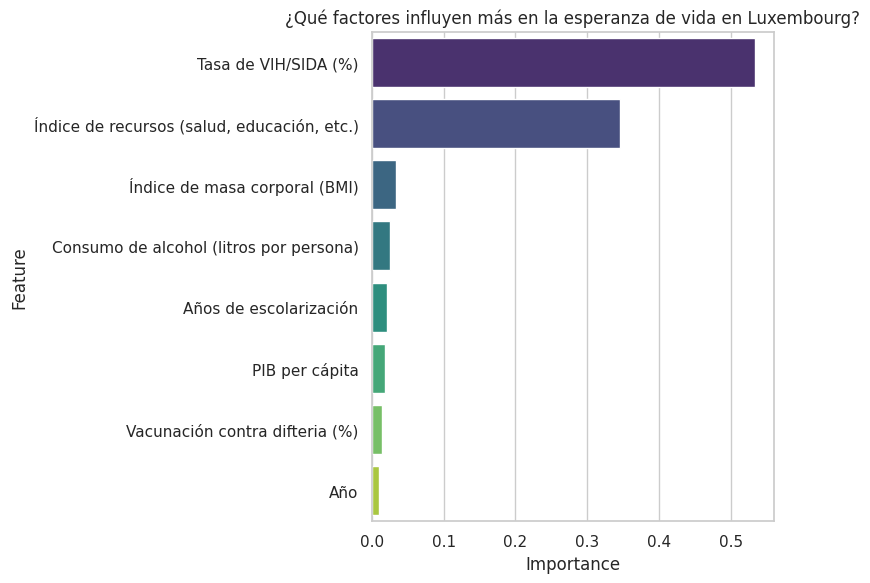

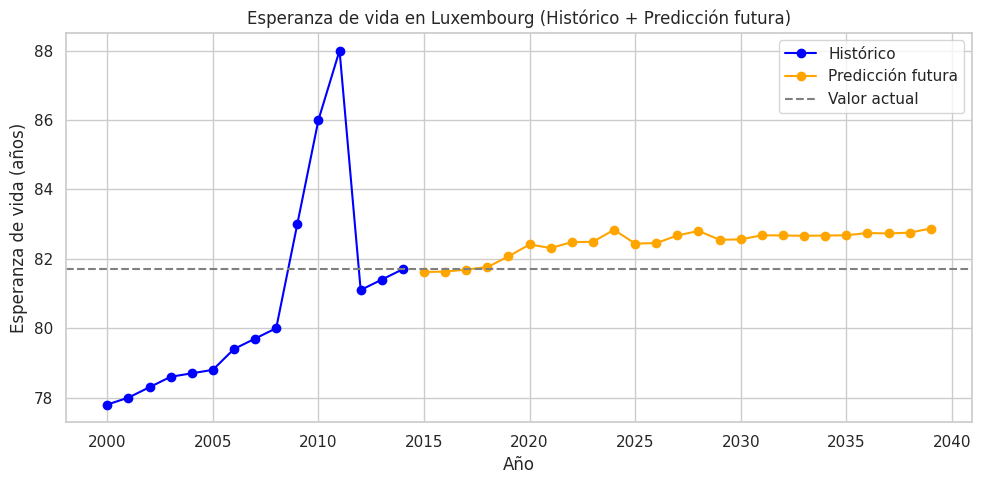

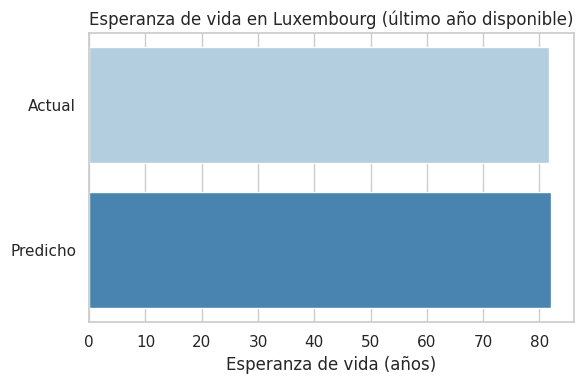

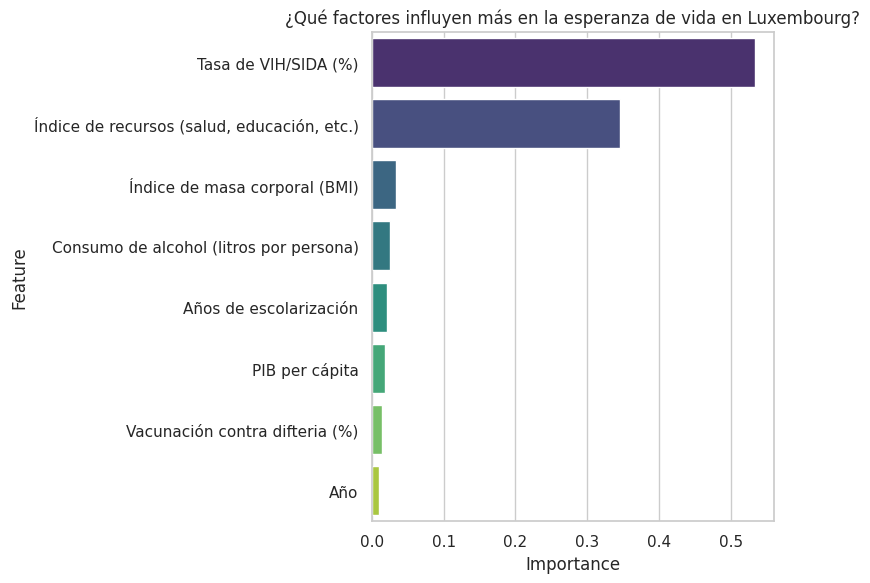

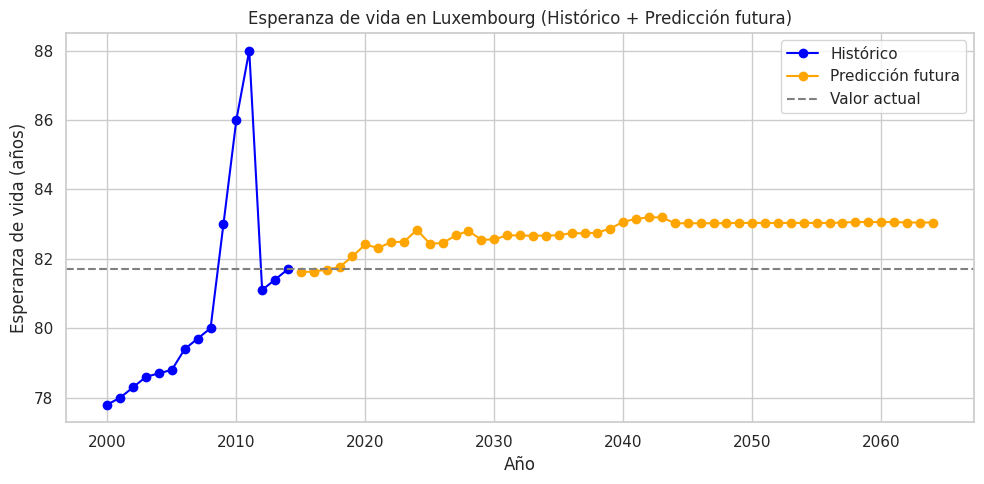

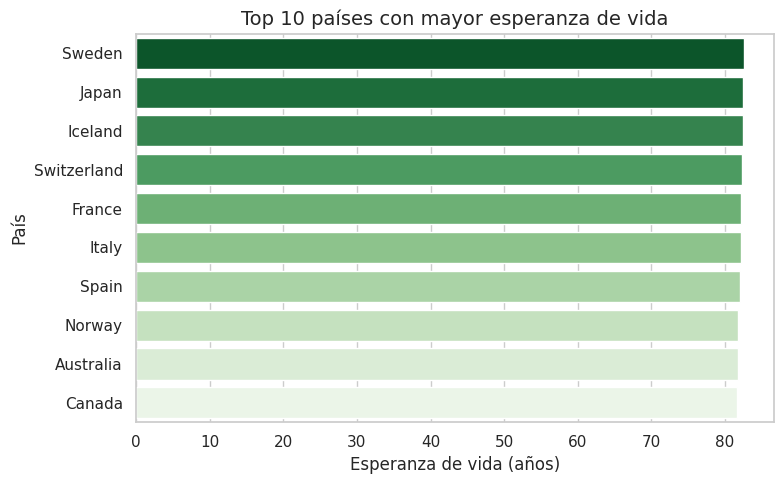

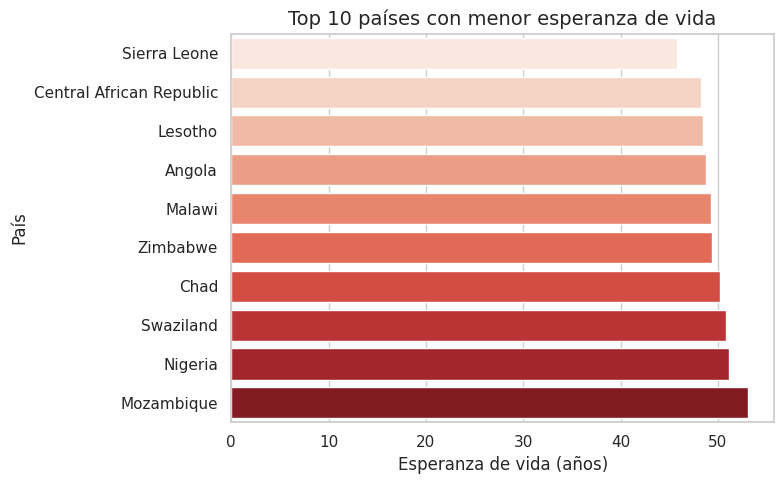

In [13]:
!pip install gradio seaborn scikit-learn plotly --quiet
!pip install pandas==2.2.2 --quiet

# ‚úÖ Importar librer√≠as necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Para Google Colab
%matplotlib inline

# üåç Cargar el dataset
url = 'https://raw.githubusercontent.com/ramapu12/trabajoFinal/59399a459ba091dfd304faa2e1bdd509b56d5477/Life%20Expectancy%20Data.csv'
df = pd.read_csv(url)

# Limpiar nombres de columnas (eliminar espacios extra y reemplazar por guiones bajos)
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)

# Variables relevantes para el modelo (sin 'Percentage_expenditure')
variables_modelo = [
    'Life_expectancy', 'Year', 'Country', 'Schooling',
    'Income_composition_of_resources', 'GDP', 'Alcohol',
    'BMI', 'Diphtheria', 'HIV/AIDS'
]

# Filtrar y eliminar filas con valores nulos
df = df[variables_modelo].dropna()
paises = sorted(df['Country'].unique())

# üéØ Entrenar modelo Random Forest
X = df.drop(columns=['Life_expectancy', 'Country'])
y = df['Life_expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de hiperpar√°metros usando GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Mejores par√°metros encontrados:", grid_search.best_params_)

# Usar el modelo con los mejores par√°metros
rf_ajustado = grid_search.best_estimator_

# üéØ Evaluaci√≥n del modelo
y_pred = rf_ajustado.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R¬≤: {r2:.2f}")

# üìà Funci√≥n para proyectar variables con regresi√≥n lineal
def proyectar_variable(df_pais, variable, anios_futuros):
    from sklearn.linear_model import LinearRegression
    datos = df_pais[['Year', variable]].dropna()
    if datos.shape[0] < 2:
        return np.repeat(datos[variable].values[-1], anios_futuros)
    X = datos['Year'].values.reshape(-1, 1)
    y = datos[variable].values
    modelo = LinearRegression().fit(X, y)
    futuros = np.arange(df_pais['Year'].max() + 1, df_pais['Year'].max() + 1 + anios_futuros).reshape(-1, 1)
    return modelo.predict(futuros)

# üé® Funci√≥n para predecir la esperanza de vida con Random Forest
def predecir_rf(pais, anios_futuros):
    datos_pais = df[df['Country'] == pais]
    if datos_pais.empty:
        return None, f"No hay datos disponibles para {pais}", None, None, ""

    entrada = datos_pais.sort_values(by='Year', ascending=False).iloc[0]
    X_input = entrada.drop(labels=['Life_expectancy', 'Country'])
    prediccion = rf_ajustado.predict([X_input])[0]

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=[entrada['Life_expectancy'], prediccion], y=['Actual', 'Predicho'],
                palette='Blues', hue=['Actual', 'Predicho'], legend=False, ax=ax)
    ax.set_title(f'Esperanza de vida en {pais} (√∫ltimo a√±o disponible)')
    ax.set_xlabel('Esperanza de vida (a√±os)')
    plt.tight_layout()

    diferencia = prediccion - entrada['Life_expectancy']
    resumen = f"\U0001F4CA Modelo predice **{prediccion:.2f} a√±os** (actual: {entrada['Life_expectancy']:.2f}) \u2794 Diferencia: **{diferencia:.2f} a√±os**"

    # Gr√°fico de importancia de caracter√≠sticas
    importances = rf_ajustado.feature_importances_
    features = X.columns
    feature_names_legibles = {
        'Year': 'A√±o',
        'Schooling': 'A√±os de escolarizaci√≥n',
        'Income_composition_of_resources': '√çndice de recursos (salud, educaci√≥n, etc.)',
        'GDP': 'PIB per c√°pita',
        'Alcohol': 'Consumo de alcohol (litros por persona)',
        'BMI': '√çndice de masa corporal (BMI)',
        'Diphtheria': 'Vacunaci√≥n contra difteria (%)',
        'HIV/AIDS': 'Tasa de VIH/SIDA (%)'
    }
    importance_df = pd.DataFrame({
        'Feature': [feature_names_legibles.get(f, f) for f in features],
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    fig_importance, ax_importance = plt.subplots(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax_importance,
                palette='viridis', hue='Feature', legend=False)
    ax_importance.set_title(f'¬øQu√© factores influyen m√°s en la esperanza de vida en {pais}?')
    plt.tight_layout()

    top_features = importance_df.head(3)
    explicacion = "\n".join([
        f"- **{row['Feature']}**: Influye significativamente en la esperanza de vida."
        for _, row in top_features.iterrows()
    ])
    texto_explicativo = f"""### üß† ¬øQu√© significa este gr√°fico?

El gr√°fico muestra los factores que m√°s influyen en la predicci√≥n de esperanza de vida para {pais}.

{explicacion}

Por ejemplo, si un pa√≠s mejora en estas √°reas, es probable que aumente la esperanza de vida en el futuro.
"""

    # Proyecci√≥n futura realista usando regresi√≥n lineal para cada variable
    future_years = np.arange(datos_pais['Year'].max() + 1, datos_pais['Year'].max() + 1 + anios_futuros)
    future_input = pd.DataFrame()

    for var in X.columns:
        if var == 'Year':
            future_input['Year'] = future_years
        else:
            future_input[var] = proyectar_variable(datos_pais, var, anios_futuros)

    predictions_future = rf_ajustado.predict(future_input)

    fig_combined, ax_combined = plt.subplots(figsize=(10, 5))
    ax_combined.plot(datos_pais['Year'], datos_pais['Life_expectancy'], label='Hist√≥rico', color='blue', marker='o')
    ax_combined.plot(future_years, predictions_future, label='Predicci√≥n futura', color='orange', marker='o')
    ax_combined.axhline(y=entrada['Life_expectancy'], color='gray', linestyle='--', label='Valor actual')

    ax_combined.set_title(f'Esperanza de vida en {pais} (Hist√≥rico + Predicci√≥n futura)')
    ax_combined.set_xlabel('A√±o')
    ax_combined.set_ylabel('Esperanza de vida (a√±os)')
    ax_combined.legend()
    plt.tight_layout()

    return fig, resumen, fig_importance, fig_combined, texto_explicativo

# üìä Gr√°ficos Top/Bottom pa√≠ses
def graficos_globales():
    mean_life = df.groupby('Country', as_index=False)['Life_expectancy'].mean()
    top = mean_life.sort_values(by='Life_expectancy', ascending=False).head(10)
    bottom = mean_life.sort_values(by='Life_expectancy', ascending=True).head(10)

    sns.set(style='whitegrid')

    fig_top, ax_top = plt.subplots(figsize=(8, 5))
    sns.barplot(x='Life_expectancy', y='Country', data=top, palette='Greens_r', hue='Country', legend=False, ax=ax_top)
    ax_top.set_title('Top 10 pa√≠ses con mayor esperanza de vida', fontsize=14)
    ax_top.set_xlabel('Esperanza de vida (a√±os)')
    ax_top.set_ylabel('Pa√≠s')
    plt.tight_layout()

    fig_bottom, ax_bottom = plt.subplots(figsize=(8, 5))
    sns.barplot(x='Life_expectancy', y='Country', data=bottom, palette='Reds', hue='Country', legend=False, ax=ax_bottom)
    ax_bottom.set_title('Top 10 pa√≠ses con menor esperanza de vida', fontsize=14)
    ax_bottom.set_xlabel('Esperanza de vida (a√±os)')
    ax_bottom.set_ylabel('Pa√≠s')
    plt.tight_layout()

    return fig_top, fig_bottom

# üåç Mapa interactivo
def mapa_esperanza():
    promedio_pais = df.groupby('Country', as_index=False)['Life_expectancy'].mean()
    fig = px.choropleth(
        promedio_pais,
        locations="Country",
        locationmode="country names",
        color="Life_expectancy",
        hover_name="Country",
        color_continuous_scale="Viridis",
        title="\U0001F30D Esperanza de vida media por pa√≠s"
    )
    fig.update_layout(height=600)
    return fig

# üìä Funci√≥n para obtener el pa√≠s con la mayor esperanza de vida
def obtener_pais_mejor_esperanza():
    mejor_pais = df[df['Life_expectancy'] == df['Life_expectancy'].max()]['Country'].values[0]
    return mejor_pais

def comparativa_con_mejor_pais(pais, anios_futuros):
    mejor_pais = obtener_pais_mejor_esperanza()

    if pais not in df['Country'].values or mejor_pais not in df['Country'].values:
        return None

    datos_pais = df[df['Country'] == pais]
    datos_mejor_pais = df[df['Country'] == mejor_pais]

    # Funci√≥n auxiliar para proyecci√≥n + predicci√≥n
    def proyectar_y_predecir(df_pais, anios):
        future_years = np.arange(df_pais['Year'].max() + 1, df_pais['Year'].max() + 1 + anios)
        future_input = pd.DataFrame()

        for var in X.columns:
            if var == 'Year':
                future_input['Year'] = future_years
            else:
                future_input[var] = proyectar_variable(df_pais, var, anios)
        pred_future = rf_ajustado.predict(future_input)
        return future_years, pred_future

    future_years_pais, pred_pais = proyectar_y_predecir(datos_pais, anios_futuros)
    future_years_mejor, pred_mejor = proyectar_y_predecir(datos_mejor_pais, anios_futuros)

    fig_comparativa, ax_comparativa = plt.subplots(figsize=(10, 5))
    ax_comparativa.plot(datos_pais['Year'], datos_pais['Life_expectancy'], label=f'{pais} (hist√≥rico)', color='blue', marker='o')
    ax_comparativa.plot(future_years_pais, pred_pais, label=f'{pais} (predicci√≥n)', color='blue', linestyle='--', marker='x')

    ax_comparativa.plot(datos_mejor_pais['Year'], datos_mejor_pais['Life_expectancy'], label=f'{mejor_pais} (hist√≥rico)', color='green', marker='o')
    ax_comparativa.plot(future_years_mejor, pred_mejor, label=f'{mejor_pais} (predicci√≥n)', color='green', linestyle='--', marker='x')

    ax_comparativa.set_title(f'Comparativa: {pais} vs {mejor_pais} (hist√≥rico + futuro)')
    ax_comparativa.set_xlabel('A√±o')
    ax_comparativa.set_ylabel('Esperanza de vida (a√±os)')
    ax_comparativa.legend()
    plt.tight_layout()

    return fig_comparativa

def generar_todo(pais, anios):
    fig_rf, resumen, fig_imp, fig_futuro, texto = predecir_rf(pais, anios)
    fig_comp = comparativa_con_mejor_pais(pais, anios)
    return fig_rf, resumen, fig_imp, fig_futuro, texto, fig_comp

# üé® Interfaz Gradio
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Comparativa Global de Esperanza de Vida")

    fig_top, fig_bottom = graficos_globales()
    with gr.Row():
        with gr.Column():
            gr.Plot(fig_top)
        with gr.Column():
            gr.Plot(fig_bottom)

    gr.Markdown("## \U0001F30D Mapa Interactivo de Esperanza de Vida (Promedio por Pa√≠s)")
    gr.Plot(mapa_esperanza())

    gr.Markdown("---")
    gr.Markdown("## Predicci√≥n por Pa√≠s (Random Forest)")

    with gr.Row():
        pais_input_rf = gr.Dropdown(choices=paises, label="Selecciona un pa√≠s")
        slider_anios = gr.Slider(minimum=5, maximum=50, value=25, step=1, label="A√±os a predecir")

    plot_rf = gr.Plot(label="Predicci√≥n RF")
    resumen_rf = gr.Markdown()
    importance_plot = gr.Plot(label="Importancia de las caracter√≠sticas")
    future_plot = gr.Plot(label="Predicci√≥n futura (pr√≥ximos a√±os)")
    explicacion_importancia = gr.Markdown()
    fig_comparativa = gr.Plot(label="Comparativa con el mejor pa√≠s") # Initialize as empty plot

    gr.Button("Generar Predicci√≥n").click(
    fn=generar_todo,
    inputs=[pais_input_rf, slider_anios],
    outputs=[plot_rf, resumen_rf, importance_plot, future_plot, explicacion_importancia, fig_comparativa]
)

# üöÄ Ejecutar la app Gradio
demo.launch(share=True)